# *DSHARP* Mie Opacity Package

### Introduction

This notebook demonstrates how to create/read our **current** set of opacities used in the DSHARP project or carries out other tests of the opacity package. This way we create the opacities in a transparent (open-source) way. In the near future, the opacities will be averaged over a narrow size distribution within each bin, to avoid resonance issues.

**Note:** All parts have their own `import` statements. This allows running those parts of the notebook separately. This also means that without the code to create the opacities, [**Part 2**](#Part-2:-Reading-in-from-default-format) can still be executed for reading in the resulting opacity files.

### Outline

- [**Part 1**](#Part-1:-Creating-the-LP-opacities) creates the default opacities (this part might be updated)
- [**Part 2**](#Part-2:-Reading-in-from-default-format) reads the created opacities (this part should stay the same)
- [**Part 3**](#Part-3:-Comparison-to-Ricci-et-al.-2010) compares the resulting opacities to the results shown in [Ricci et al. 2010](https://dx.doi.org/10.1051/0004-6361/200913403)
- [**Part 4**](#Part-4:-Comparison-to-Draine-opacities) tests our Mie implementation to reproduce the astronomical silicates opacities by [Draine & Lee 1984](https://doi.org/10.1086/162480)
- [**Part 5**](#Part-5:-Test-large-grain-extrapolation) tests the extrapolation that can be used to speed up the calculations in the geometric optics limit.
- [**Part 6**](#Part-6:-Pollack-opacities) uses the Henning opacity database to calculate the [Pollack et al. 1994](https://doi.org/10.1086/173677) opacities and also recreates their Fig. 4 comparing the optical constants.

### The Code

The opacity package used here is now part of `DISKLAB`. To install the Large Program Opacity package `lp_opac` you can download code from [github](https://github.com/dullemond/DISKLAB) once it's made public, change into that directory, and install the package with the command

    pip install -e .
    
Until then, you can use the copy in `p484/projects/opacity/disklab`.

-------------------------------------
## Part 1: Creating the LP opacities

### Procedure

The opacity is created in the following way, following [Ricci et al. 2010](https://dx.doi.org/10.1051/0004-6361/200913403):

| Optical constants                                                                | Volume fractions [%] | material density [g/cm^3] |
|:---------------------------------------------------------------------------------|---------------------:|--------------------------:|
| Astronomical Silicates: [Draine 2003](https://dx.doi.org/10.1086/379123)         |           7          |            3.50           |
| Carbon  grains: [Zubko et al. 1996](https://dx.doi.org/10.1093/mnras/282.4.1321) |          21          |            2.50           |
| Water ice: [Warren & Brandt 2008](https://dx.doi.org/10.1029/2007JD009744)       |          42          |            1.00           |
| Vacuum                                                                           |          30          |            0.00           |

The mixing of the optical constants is done according to the Bruggeman mixing rule and the opacities are calculated using a Bohren & Huffman Mie code, more specifically a Fortran 90 translation of [Bruce Draines `bhmie.f`](https://www.astro.princeton.edu/~draine/scattering.html) code.

Imports for this part:

In [1]:
import numpy as np
from disklab import opacity

Here we create the opacities: note that the large grains at short wavelength take very long to calculate. We can use extrapolation for that by setting `extrapolate_large_grains=True` which make it very fast, but for the extreme cases ($a>1$ cm, $\lambda < 50\mu$m) this leads to a few percent error, and for the most extreme cases ($a>10$ cm, $\lambda < 0.2\mu$m) to an error of 30%.

In [2]:
a = np.logspace(-5, 2, 200)
lam = np.logspace(np.log10(6.5e-6), 0, 206)

res = opacity.get_opacities(a, lam, return_all=True, extrapol=True, extrapolate_large_grains=False)

k_abs = res['k_abs']
k_sca = res['k_sca']
g     = res['g_sca']
S1    = res['S1']
S2    = res['S2']
theta = res['theta']
rho_s = res['rho_s']

Note: wavelength range outside data. Extrapolation will be done but is uncertain.
material: Water Ice: Warren & Brandt (2008), downloading IOP_2008_ASCIItable.dat: ... 
Done!
Mie ... 0 %

disklab/opacity/lp_opac.py:1240: UserWarning: large size parameter: nmx=96666242.08825111 - this can take long
  warnings.warn('large size parameter: nmx={} - this can take long'.format(nmx))


Mie ... Done!


Store the data

In [3]:
np.savez_compressed('default_opacities', a=a, lam=lam, k_abs=k_abs.T, k_sca=k_sca.T, g=g)

--------------------------------
## Part 2: Reading in from default format

This part demonstrates how to read in the pre-calculated opacities. As we update [Part 1](#Part-1:-Creating-the-LP-opacities), the opacities might change slightly, but this part should stay the same.

Imports for this part:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use([{'figure.dpi':150, 'image.cmap':'rocket'}])

Loading the data

In [2]:
data = np.load('default_opacities.npz')

a = data['a']
lam = data['lam']
k_abs = data['k_abs']
k_sca = data['k_sca']
g = data['g']

Example plot: opacities of the smallest grains as function of wavelength

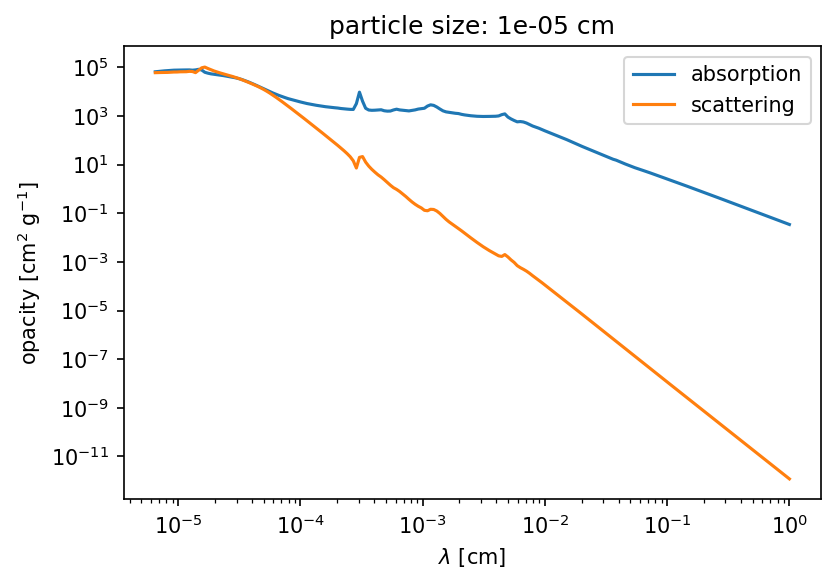

In [3]:
ia = 0
f, ax = plt.subplots()
ax.loglog(lam, k_abs[:, ia], label='absorption')
ax.loglog(lam, k_sca[:, ia], label='scattering')
ax.set_title(f'particle size: {a[ia]} cm')
ax.set_ylabel('opacity [cm$^2$ g$^{-1}$]')
ax.set_xlabel('$\lambda$ [cm]')
ax.legend();

Example plot: opacities at 880 µm as function of particle size

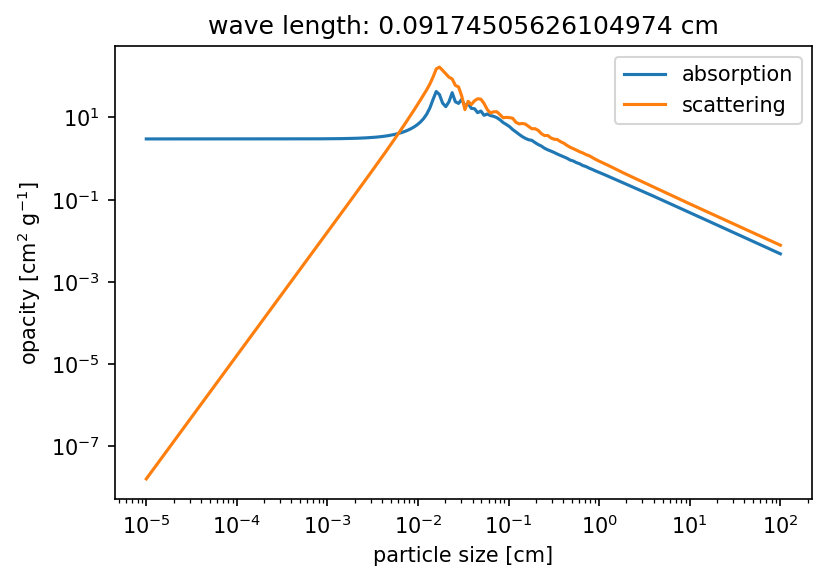

In [4]:
ilam = lam.searchsorted(0.088)
f, ax = plt.subplots()
ax.loglog(a, k_abs[ilam, :], label='absorption')
ax.loglog(a, k_sca[ilam, :], label='scattering')
ax.set_title('wave length: {} cm'.format(lam[ilam]))
ax.set_ylabel('opacity [cm$^2$ g$^{-1}$]')
ax.set_xlabel('particle size [cm]')
ax.legend();

------------------------------------------
## Part 3: Comparison to Ricci et al. 2010

Comparison of size-averaged opacities to Luca Riccis data file.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from pkg_resources import resource_filename
plt.style.use(['seaborn',{'figure.dpi':150}])

from disklab import opacity

Load default opacity from file

In [2]:
data = np.load('default_opacities.npz')

a = data['a']
lam = data['lam']
k_abs = data['k_abs']
k_sca = data['k_sca']
g = data['g']

Load Lucas averaged opacity data.

In [3]:
datafile = resource_filename(opacity.__name__, os.path.join('optical_constants', 'testfiles_ricci', 'kappa.dat'))
luca = np.loadtxt(datafile)

Compare the averaged opacity curves

kappa_abs @ 1 mm for a_max = 1mm : 11.1 cm^2/g
kappa_abs @ 0.88 mm for a_max = 1mm : 12.9 cm^2/g


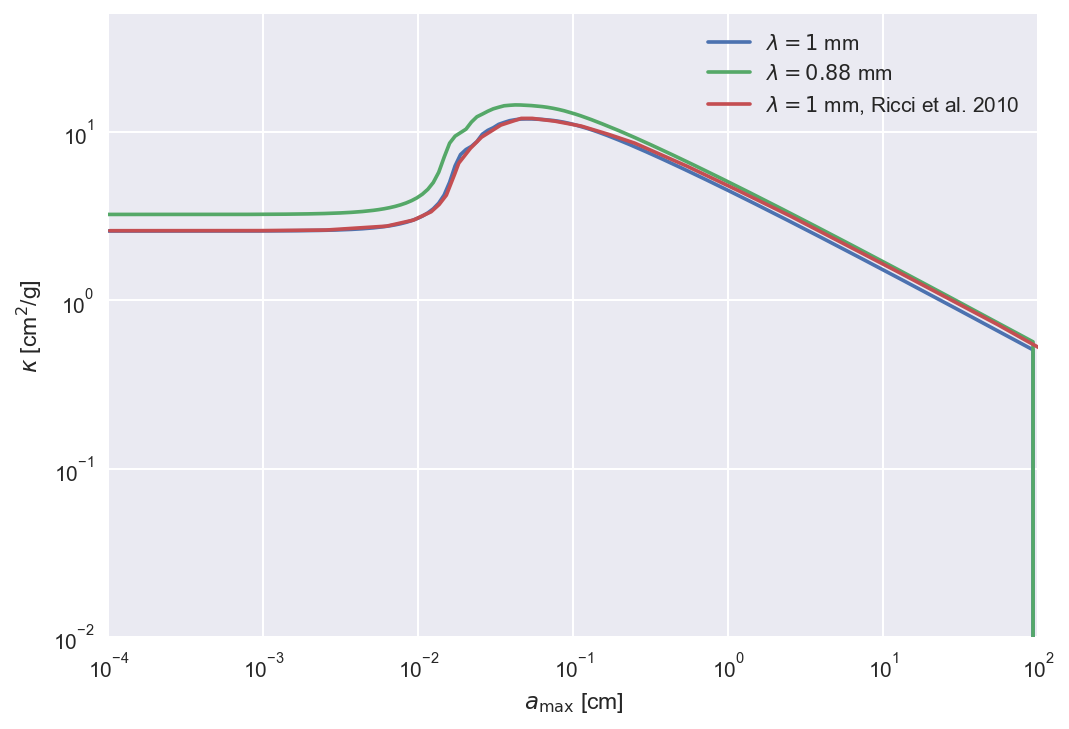

In [4]:
f, ax = plt.subplots()
for lam_avg in [0.1, 0.088]:
    
    # interpolate at the observed frequencies
    
    k_a = np.array([np.interp(lam_avg, lam, k_abs[:,ia]) for ia in range(len(a))])
    k_s = np.array([np.interp(lam_avg, lam, k_sca[:,ia]) for ia in range(len(a))])

    # average over size distributions
    
    k = np.zeros_like(a)
    for ia in range(len(a)-1):
        s = (a/a[0])**0.5
        s[ia+1:]=1e-100
        s = s/s.sum()
        k[ia] = np.sum(k_a*s)
        
    ax.loglog(a,k, label='$\lambda = {:2.2g}$ mm'.format(lam_avg*10))
    
    print('kappa_abs @ {:.3g} mm for a_max = 1mm : {:.3g} cm^2/g'.format(lam_avg*10, np.interp(0.1, a, k)))
    
ax.set_xlabel('$a_\mathrm{max}$ [cm]')
ax.set_ylabel('$\kappa$ [cm$^2$/g]')
ax.set_xlim(1e-4, 1e2)
ax.set_ylim(0.01, 50)

ax.loglog(luca[:,0], luca[:,1], label='$\lambda = 1$ mm, Ricci et al. 2010')
ax.legend()
f.savefig('opac.pdf')

-----------------------------------------
## Part 4: Comparison to Draine opacities

To check if our Mie calculation works properly, we compare our calculaitons to the results from [Bruce Draines](https://www.astro.princeton.edu/~draine/dust/dust.diel.html) website, which has both the optical properties and the opacities.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn',{'figure.dpi':150}])

from disklab import opacity

In [2]:
a = np.logspace(-5, 2, 150)
lam = np.logspace(np.log10(6.5e-6), 0, 206)

# draine optical constants go only until 1mm, so we extrapolate

dc = opacity.diel_dl84_astrosil()
dc.extrapolate_constants_up(4e-2, 1e0, kind='linear')

res = opacity.get_mie_coefficients(a, lam, dc, extrapolate_large_grains=False)

Mie ... 0 %

disklab/opacity/lp_opac.py:1240: UserWarning: large size parameter: nmx=96666242.08825111 - this can take long
  warnings.warn('large size parameter: nmx={} - this can take long'.format(nmx))


Mie ... Done!


Read pre-calculated opacities for 0.1 µm particles from [Bruce Draines](https://www.astro.princeton.edu/~draine/dust/dust.diel.html) website:

In [3]:
from urllib.request import urlopen
with urlopen('ftp://ftp.astro.princeton.edu/draine/dust/diel/Sil_21') as f:
    
    # skip to the right particle size
    
    line = b''
    while not f.readline().decode().startswith('1.000E-01 = radius(micron)'):
        pass
    line = f.readline()
    
    # read the right number of lines
    
    draine = np.loadtxt([f.readline() for i in range(241)])

Plot the calculated opacity against the one on Bruce Draines website.

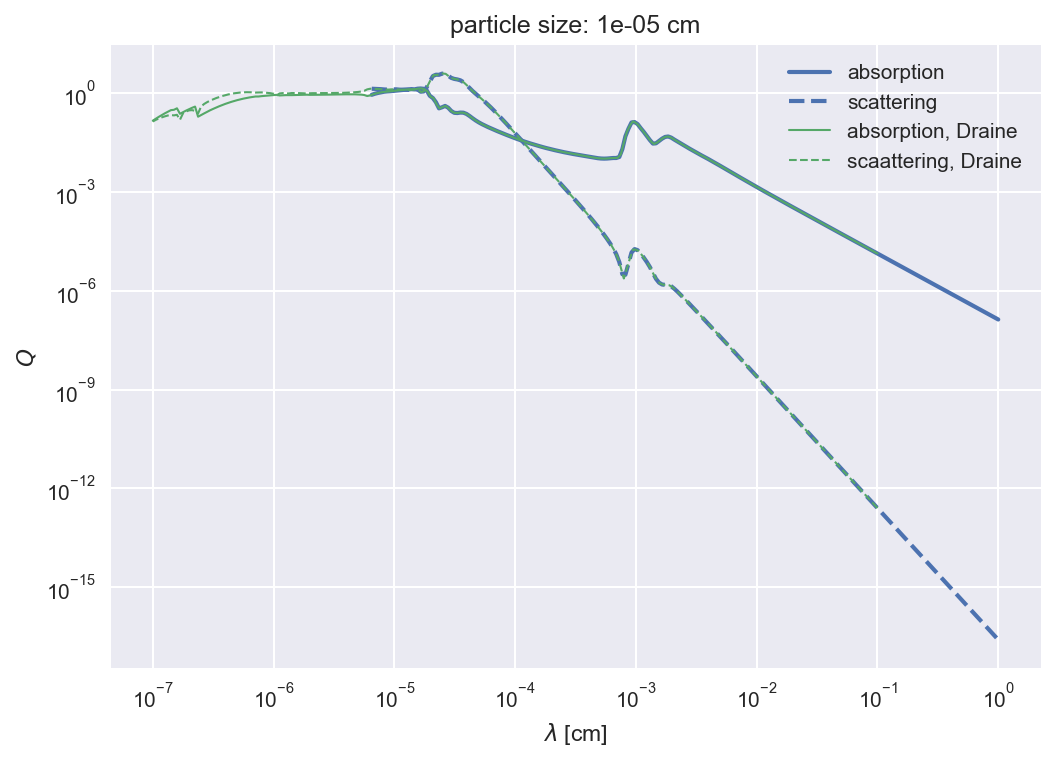

In [4]:
ia = 0
f, ax = plt.subplots()
line1, = ax.loglog(lam, res['q_abs'][ia, :], '-',      lw=2, label='absorption')
line2, = ax.loglog(lam, res['q_sca'][ia, :], '--',     lw=2, label='scattering', c=line1.get_color())
line3, = ax.loglog(draine[:,0]*1e-4, draine[:,1], '-', lw=1, label='absorption, Draine')
line4, = ax.loglog(draine[:,0]*1e-4, draine[:,2], '--',lw=1, label='scaattering, Draine', c=line3.get_color())

ax.set_title(f'particle size: {a[ia]} cm')
ax.set_ylabel('$Q$')
ax.set_xlabel('$\lambda$ [cm]')
ax.legend();

Calculate $\beta$ as function of $a_\mathrm{max}$:

kappa_abs @ 1 mm for a_max = 1mm : 3.6 cm^2/g
kappa_abs @ 0.88 mm for a_max = 1mm : 4.34 cm^2/g


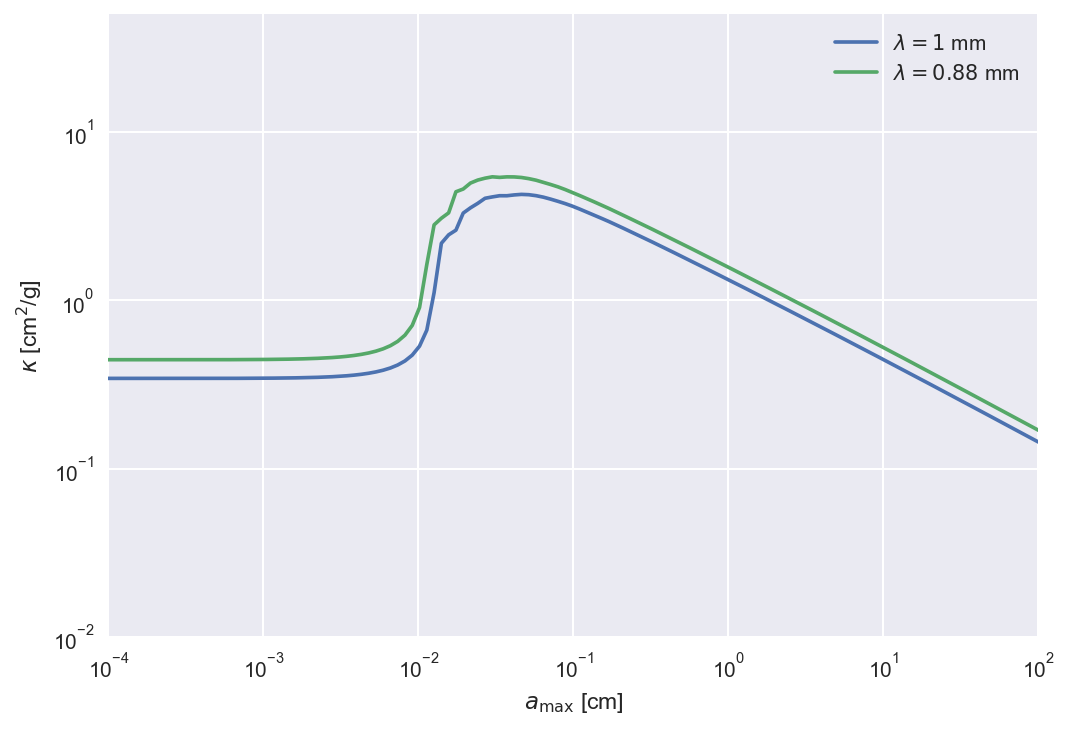

In [5]:
rho_s = 3.0
m     = 4.0 * np.pi / 3.0 * rho_s * a**3
k_abs, k_sca = opacity.get_kappa_from_q(a, m, res['q_abs'], res['q_sca'])

f, ax = plt.subplots()
for lam_avg in [0.1, 0.088]:
    
    # interpolate at the observed frequencies
    
    k_a = np.array([np.interp(lam_avg, lam, k_abs[ia, :]) for ia in range(len(a))])
    k_s = np.array([np.interp(lam_avg, lam, k_sca[ia, :]) for ia in range(len(a))])

    # average over size distributions
    
    k = np.zeros_like(a)
    for ia in range(len(a)):
        s = (a/a[0])**0.5
        if ia<len(a)-1:
            s[ia+1:]=1e-100
        s = s/s.sum()
        k[ia] = np.sum(k_a*s)
        
    ax.loglog(a,k, label='$\lambda = {:2.2g}$ mm'.format(lam_avg*10))
    
    print('kappa_abs @ {:.3g} mm for a_max = 1mm : {:.3g} cm^2/g'.format(lam_avg*10, np.interp(0.1, a, k)))
    
ax.set_xlabel('$a_\mathrm{max}$ [cm]')
ax.set_ylabel('$\kappa$ [cm$^2$/g]')
ax.set_xlim(1e-4, 1e2)
ax.set_ylim(0.01, 50)
ax.legend()
f.savefig('opac.pdf');

-----------------------------------------
## Part 5: Test large grain extrapolation

For large size parameters (large grains and short wavelength), the Mie solution needs many terms. In this case, we can also use a direct extrapolation since we are in the geometric optics case. In this part, we compare those two approaches.

The file `default_opacities.npz` was created in [Part 1](#Part-1:-Creating-the-LP-opacities), the file `default_opacities_extr.npz` was created in the same way, but setting `extrapolate_large_grains=True`.

Imports for this part:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use([{'figure.dpi':150, 'image.cmap':'rocket'}])

Loading the data

In [2]:
d      = np.load('default_opacities.npz')
a      = d['a']
lam    = d['lam']
k_abs  = d['k_abs']
k_sca  = d['k_sca']

d2     = np.load('default_opacities_extr.npz')
k_abs2 = d2['k_abs']
k_sca2 = d2['k_sca']

Plot the opacities and the errors

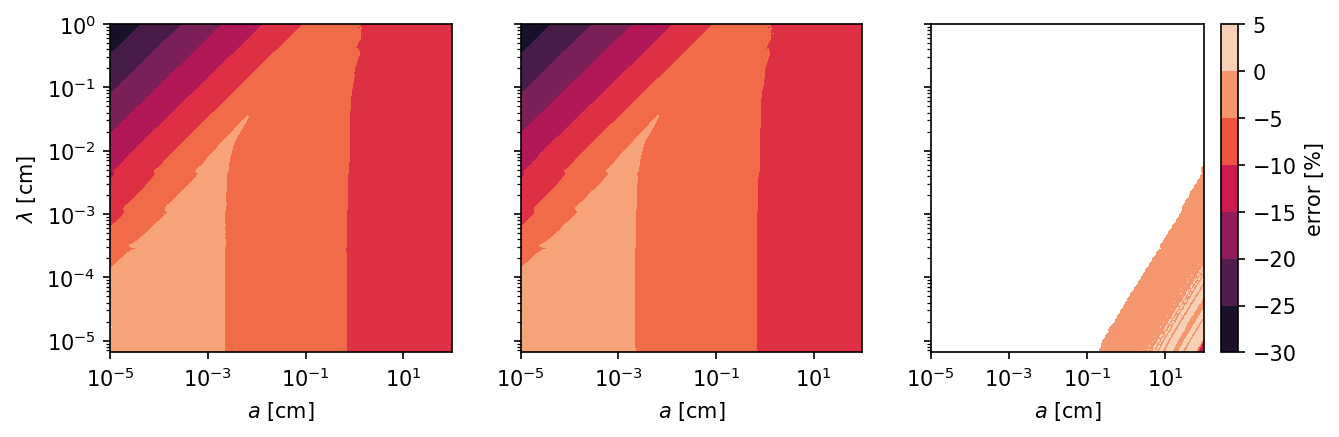

In [3]:
f, ax = plt.subplots(1,3, figsize=(10,3), sharex=True, sharey=True)

ax[0].contourf(a, lam, np.log10(k_sca))
ax[1].contourf(a, lam, np.log10(k_sca2))
for _a in ax:
    _a.set_xscale('log')
    _a.set_yscale('log')
    _a.set_xlabel('$a$ [cm]')
    
ax[0].set_ylabel('$\lambda$ [cm]')
    
err = k_sca/k_sca2-1
cc = ax[2].contourf(a, lam, np.ma.array(err*100, mask=err==0))
cb = plt.colorbar(cc)
cb.set_label('error [%]')
f.subplots_adjust(bottom=0.15, hspace=0)
f.savefig('opacitiy_comparison.pdf')

----------------------------
## Part 6: Pollack opacities

Here we try to reproduce the opacities of [Pollack et al. 1994](https://doi.org/10.1086/173677). For the optical constants, we use the ones provided by [Thomas Henning](http://www2.mpia-hd.mpg.de/home/henning/Dust_opacities/Opacities/RI/old_ri.html), specifically the old ones. For the Refractory and volatile organics, we use the same optical properties. As mixing rule, we use Maxwell-Garnett, as in the Pollack paper.

$\bar\rho$ = 1.3785 g/cc


| Species            | Bulk Density [g/cm^3] | mass fraction total | mass fraction normalized | volume fraction |
|:-------------------|:----------------------|:--------------------|:-------------------------|:----------------|
| Metallic iron      | 7.87                  | 1.26e-4             | 0.00900901               | 0.00157800      |
| Olivine            | 3.49                  | 2.64e-3             | 0.18876019               | 0.07455709      |
| Orthopyroxene      | 3.40                  | 7.70e-4             | 0.05505506               | 0.02232144      |
| Troilite           | 4.83                  | 7.68e-4             | 0.05491205               | 0.01567200      |
| Refractory organic | 1.50                  | 3.53e-3             | 0.25239525               | 0.23194974      |
| Volatile organic   | 1.00                  | 6.02e-4             | 0.04304304               | 0.05933445      |
| Water ice          | 0.92                  | 5.55e-3             | 0.39682540               | 0.59458728      |

Imports for this part:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from disklab import opacity
plt.style.use(['seaborn-ticks', {'figure.dpi': 100}])

In [2]:
# get the optical constants

d1 = opacity.diel_henning('iron',          new=False)
d2 = opacity.diel_henning('olivine',       new=False)
d3 = opacity.diel_henning('orthopyroxene', new=False)
d4 = opacity.diel_henning('troilite',      new=False)
d5 = opacity.diel_henning('organics',      new=False)
d6 = opacity.diel_henning('organics',      new=False)
d7 = opacity.diel_henning('waterice',      new=False)

# define arrays for optical constants, bulk densities, and volume fractions for each species

constants = [d1, d2, d3, d4, d5, d6, d7]
densities = np.array([7.87, 3.49, 3.40, 4.83, 1.50, 1.00, 0.92])
vol_fract = np.array([
    0.00157800,
    0.07455709,
    0.02232144,
    0.01567200,
    0.23194974,
    0.05933445,
    0.59458728
    ])

# calculate the mean density, needed to get opacity in units of cm^2/g

rho_s = (vol_fract*densities).sum()

# mix the optical constants using the Maxwell-Garnett rule

d = opacity.diel_mixed(constants, vol_fract, rule='Maxwell-Garnett')

Reading opacities from iron
Reading opacities from olivine
Reading opacities from orthopyr
Reading opacities from troilite
Reading opacities from organics
Reading opacities from organics
Reading opacities from waterice


Calculate the Mie opacities, this takes quite long if `extrapolate_large_grains=False`.

In [3]:
a = np.logspace(-5, 2, 150)
lam = np.logspace(np.log10(1e-5), 0, 206)

res = opacity.get_opacities(a, lam, rho_s=rho_s, diel_const=d, return_all=True, extrapol=True, extrapolate_large_grains=True)

k_abs = res['k_abs']
k_sca = res['k_sca']
g     = res['g_sca']
S1    = res['S1']
S2    = res['S2']
theta = res['theta']
rho_s = res['rho_s']

Mie ... Done!


Redo [Fig. 1](http://adsbit.harvard.edu//full/1994ApJ...421..615P/0000624.000.html) from Pollack et al. 1994 paper to compare optical constants.

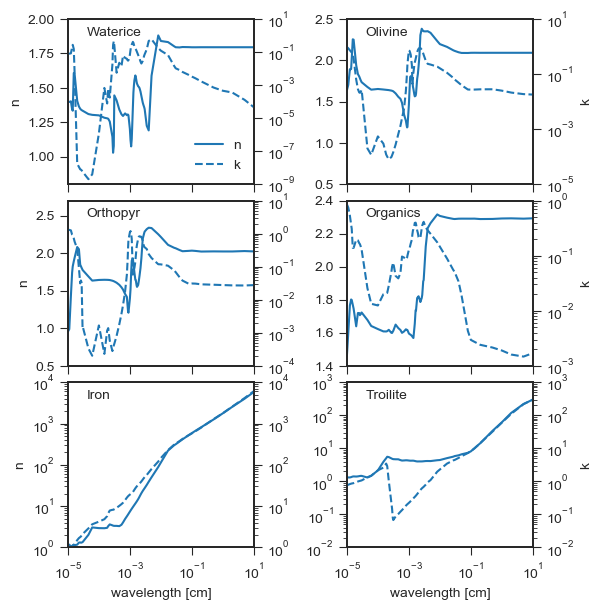

In [4]:
f, axs = plt.subplots(3,2, figsize=(6,7), sharex=True)

plot_const = [d7, d2, d3, d5, d1, d4]

axs = axs.ravel()
axs2 = []
for c,ax in zip(plot_const, axs):

    # plot real part

    line1, = ax.semilogx(c._l, c._n, '-', label='n')

    # plot imaginary part

    ax2 = ax.twinx()
    line2, = ax2.loglog(c._l, c._k, '--', label='k')
    axs2 +=[ax2]

    # add name of the species

    ax.text(.1,.9,
            os.path.splitext(os.path.split(c.datafile)[1])[0].capitalize(),
            horizontalalignment='left',
            transform=ax.transAxes)

    # add legend to first panel

    if len(axs2)==1:
        lns = [line1,line2]
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc=4)

# adjust the labels

for ax in axs[:-2]:
    plt.setp(ax.get_xticklabels(), visible=False)
for ax in axs[-2:]:
    ax.set_xlabel('wavelength [cm]')
for ax in axs[0::2]:
    ax.set_ylabel('n')
for ax in axs2[1::2]:
    ax.set_ylabel('k')

# use same limits as in pollack paper

axs[0].set_ylim(0.8,2.0)
axs[1].set_ylim(0.5,2.5)
axs[2].set_ylim(0.5,2.7)
axs[3].set_ylim(1.4,2.4)
axs[4].set_ylim(1e0,1e4)
axs[4].set_yscale('log')
axs[5].set_ylim(1e-2,1e3)
axs[5].set_yscale('log')

axs2[0].set_ylim(1e-9,1e1)
axs2[1].set_ylim(1e-5,1e1)
axs2[2].set_ylim(1e-4,1e1)
axs2[3].set_ylim(1e-3,1e0)
axs2[4].set_ylim(1e-0,1e4)
axs2[5].set_ylim(1e-2,1e3)

axs[0].set_xlim(1e-5, 1e1)

f.subplots_adjust(hspace=0.1, wspace=0.5)
f.savefig('pollack_optical_constants.pdf')

Calculate $\beta$ as function of $a_\mathrm{max}$:

kappa_abs @ 1 mm for a_max = 1mm : 1.16 cm^2/g
kappa_abs @ 0.88 mm for a_max = 1mm : 1.38 cm^2/g


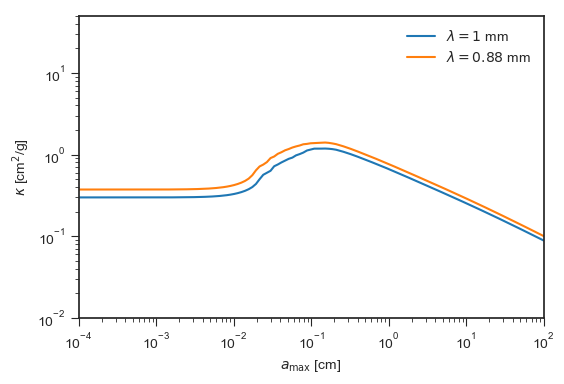

In [5]:
m     = 4.0 * np.pi / 3.0 * rho_s * a**3

f, ax = plt.subplots()
for lam_avg in [0.1, 0.088]:
    
    # interpolate at the observed frequencies
    
    k_a = np.array([np.interp(lam_avg, lam, k_abs[ia, :]) for ia in range(len(a))])
    k_s = np.array([np.interp(lam_avg, lam, k_sca[ia, :]) for ia in range(len(a))])

    # average over size distributions
    
    k = np.zeros_like(a)
    for ia in range(len(a)):
        s = (a/a[0])**0.5
        if ia<len(a)-1:
            s[ia+1:]=1e-100
        s = s/s.sum()
        k[ia] = np.sum(k_a*s)
        
    ax.loglog(a,k, label='$\lambda = {:2.2g}$ mm'.format(lam_avg*10))
    
    print('kappa_abs @ {:.3g} mm for a_max = 1mm : {:.3g} cm^2/g'.format(lam_avg*10, np.interp(0.1, a, k)))
    
ax.set_xlabel('$a_\mathrm{max}$ [cm]')
ax.set_ylabel('$\kappa$ [cm$^2$/g]')
ax.set_xlim(1e-4, 1e2)
ax.set_ylim(0.01, 50)
ax.legend()
f.savefig('opac.pdf');